<a href="https://colab.research.google.com/github/DanieleAngioni97/Introductory-Seminar-PyTorch/blob/main/notebooks/03_computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import torch
from torch import nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt

assert torch.cuda.is_available()

# Representing images

(1000, 1000, 3)


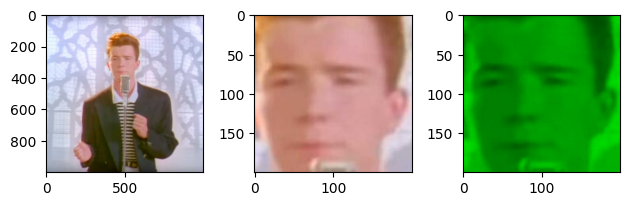

In [1]:
from PIL import Image
import requests
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt

url = 'https://static.wikia.nocookie.net/fansekai/images/1/1d/HA_HA_HA_HA.jpg/'\
       'revision/latest/scale-to-width-down/1000?cb=20220807225343'
response = requests.get(url)
img = Image.open(BytesIO(response.content))
np_img = np.array(img)
print(np_img.shape)

fig, axs = plt.subplots(nrows=1, ncols=3)
axs[0].imshow(np_img)
axs[1].imshow(np_img[200:400, 400:600, :])

np_img[:, :, 0] = 0
np_img[:, :, 2] = 0
axs[2].imshow(np_img[200:400, 400:600, :])
fig.tight_layout()
fig.show()

## Tensor Images

In [2]:
import torchvision
transform = torchvision.transforms.ToTensor()
torch_img = transform(np_img)
print(np_img.max())
print(torch_img.max())
print(np_img.shape)
print(torch_img.shape)

254
tensor(0.9961)
(1000, 1000, 3)
torch.Size([3, 1000, 1000])


## Normalizing the data

In [3]:
normalizer = torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                              std=[0.5, 0.5, 0.5])
norm_img = normalizer(torch_img)
print(f"Before normalization: [{torch_img.min()}, {torch_img.max()}]")
print(f"After normalization: [{norm_img.min()}, {norm_img.max()}]")

Before normalization: [0.0, 0.9960784316062927]
After normalization: [-1.0, 0.9921568632125854]


## A dataset of tiny images: MNIST
The MNIST database of handwritten digits has a training set of 60,000 examples, and a test set of 10,000 examples.
Each of these B/W image has a shape of [28 × 28] and represents a digit from 0 to 9.
The labels are, as well, numbers from 0 to 9.

Common datasets can be easily downloaded using the `torchvision.datasets` package


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16020271.03it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 493677.79it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3759946.48it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 6940083.34it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Samples in training set: 60000
Samples in testing set: 60000


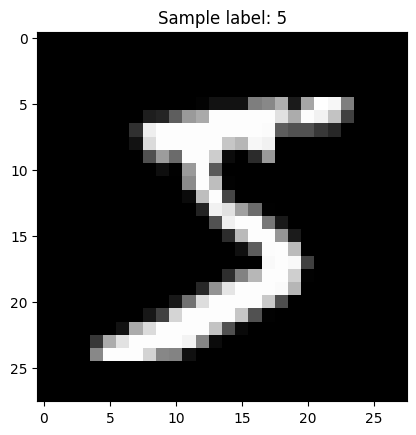

In [4]:
from torchvision import datasets
import matplotlib.pyplot as plt

data_path = 'data'
train_set = datasets.MNIST(root=data_path,
                           train=True,
                           download=True)
test_set = datasets.MNIST(root=data_path,
                          train=True,
                          download=True)

print(f"Samples in training set: {len(train_set)}")
print(f"Samples in testing set: {len(test_set)}")

image, label = train_set[0]
plt.imshow(image, cmap='gray')
plt.title(f"Sample label: {label}")
plt.show()

## Dataset transformations
We  can also apply the transform to the whole dataset at loading time


In [9]:
from torchvision import datasets, transforms

data_path = 'data'
transformed_train_set = datasets.MNIST(root=data_path,
                                       train=True,
                                       download=True,
                                       transform=transforms.ToTensor())
transformed_test_set = datasets.MNIST(root=data_path,
                                       train=False,
                                       download=True,
                                       transform=transforms.ToTensor())
sample, label = transformed_train_set[0]
print(type(sample), sample.dtype, sample.shape)

<class 'torch.Tensor'> torch.float32 torch.Size([1, 28, 28])


## Loading the dataset in batches
Even with a dataset of small images it can be hard to load in memory all the dataset at once.
In PyTorch we can use the `DataLoader` class to dynamically load a given subset of samples at a time.
We can specify the `batch_size` and optionally shuffle the samples before loading them.


In [11]:
from torch.utils.data import DataLoader

train_loader = DataLoader(transformed_train_set,
                          batch_size=64,
                          shuffle=True)
test_loader = DataLoader(transformed_train_set,
                         batch_size=64,
                         shuffle=False)

The dataloader can become an iterator by calling the `iter` function:


In [12]:
samples, labels = next(iter(train_loader))
print(samples.shape, labels.shape)

torch.Size([64, 1, 28, 28]) torch.Size([64])


Or also by putting it in a for loop:


In [13]:
for samples, labels in train_loader:
    print(samples.shape, labels.shape)
    break # just do the first iteration

torch.Size([64, 1, 28, 28]) torch.Size([64])


# Training a Neural Network to recognize digits
Similar to what already seen in the last chapter, we can use an MLP by considering each B/W pixel value as a feature.
Since each image has dimension 28x28=784 we need 784 neurons in the first layer, while we need 10 neurons for the output, one for each class (digits from 0 to 9)
For the hidden dimension we choose for example to use 10 neurons.


## Defining the MLP architecture

In [15]:
from torch import nn

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, 10)
        self.activation = nn.ReLU()

    def forward(self, x):
        # we have to flatten the samples that are 28x28
        x = x.view(-1, 784)
        x = self.activation(self.linear1(x))
        x = self.linear2(x)
        return x

Using the method `.view(-1, 784)` tells PyTorch to infer the first dimension so that the second one is equal to 784.
In this case the first dimension will be the batch size, that will be inferred automatically.

## Training the MLP

In [16]:
from torch.optim import SGD
from torch.nn import CrossEntropyLoss

def training_pipeline(model,
                      train_loader,
                      epochs=10,
                      learning_rate=1e-2
                      ):
    optimizer = SGD(model.parameters(), lr=learning_rate)
    loss_fn = CrossEntropyLoss()
    model.cuda()       # send model parameters to the GPU
    model.train()       # set the training mode
    loss_path = []      # list to store the running loss values
    # iterations over the whole train_set
    for epoch in range(epochs):
        # iterations over each batch
        for batch_idx, (samples, labels) in enumerate(train_loader):
            # send the data to the GPU
            samples = samples.cuda()
            labels = labels.cuda()

            out = model(samples)        # forward pass
            loss = loss_fn(out, labels) # compute the loss
            loss.backward()             # backpropagate the gradients
            optimizer.step()            # update the parameters
            optimizer.zero_grad()       # reset the gradients

            loss_path.append(loss.item())   # store last loss value
            # Debugging prints every N iterations
            if batch_idx % 100 == 0:
               print(f"Epoch [{epoch + 1}/{epochs}], "\
                     f"Batch [{batch_idx + 1}/{len(train_loader)}], "\
                     f"Loss: {loss.item()}")
    return loss_path

In [19]:
model = MLP()
torch.manual_seed(0)
loss_path = training_pipeline(model, train_loader,
                              epochs=10, learning_rate=1e-2)

Epoch [1/10], Batch [1/938], Loss: 2.318580150604248
Epoch [1/10], Batch [101/938], Loss: 2.056871175765991
Epoch [1/10], Batch [201/938], Loss: 1.7237783670425415
Epoch [1/10], Batch [301/938], Loss: 1.4193288087844849
Epoch [1/10], Batch [401/938], Loss: 1.11794912815094
Epoch [1/10], Batch [501/938], Loss: 0.9263314604759216
Epoch [1/10], Batch [601/938], Loss: 0.849130392074585
Epoch [1/10], Batch [701/938], Loss: 0.6785534024238586
Epoch [1/10], Batch [801/938], Loss: 0.6713349223136902
Epoch [1/10], Batch [901/938], Loss: 0.6092219948768616
Epoch [2/10], Batch [1/938], Loss: 0.6750780344009399
Epoch [2/10], Batch [101/938], Loss: 0.6277587413787842
Epoch [2/10], Batch [201/938], Loss: 0.5458136200904846
Epoch [2/10], Batch [301/938], Loss: 0.5321364402770996
Epoch [2/10], Batch [401/938], Loss: 0.5206142067909241
Epoch [2/10], Batch [501/938], Loss: 0.5537541508674622
Epoch [2/10], Batch [601/938], Loss: 0.5598397254943848
Epoch [2/10], Batch [701/938], Loss: 0.5108216404914856
E

Text(0, 0.5, 'Loss')

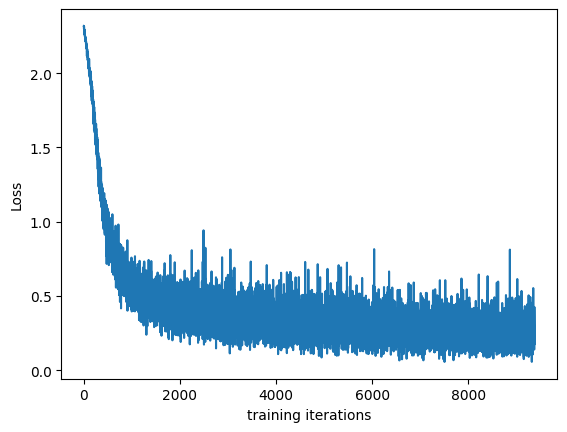

In [20]:
import matplotlib.pyplot as plt
plt.plot(loss_path)
plt.xlabel('training iterations')
plt.ylabel('Loss')

## Evaluating the model

In [21]:
def evaluate_accuracy(model, test_loader):
    correct = 0
    n_samples = 0
    model.cuda()    # put the model parameters in the GPU
    model.eval()    # set the eval mode
    with torch.no_grad():
        for samples, labels in test_loader:
            # load data in the GPU
            samples = samples.cuda()
            labels = labels.cuda()
            out = model(samples)
            y_preds = out.argmax(dim=1)
            correct += (y_preds == labels).sum()
            n_samples += samples.shape[0]
    return correct / n_samples

In [22]:
accuracy = evaluate_accuracy(model, test_loader)
print(f"Accuracy on the test set: {accuracy.item():.3f}")

Accuracy on the test set: 0.932


In [23]:
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Lambda
from torch.utils.data import DataLoader

def shift_pixels(t, shift=3):
    # shift the tensor of <shift> pixels
    return torch.roll(t, shift)

transforms = Compose([ToTensor(), Lambda(shift_pixels)])
shifted_test_set = datasets.MNIST(root=data_path,
                                  train=False,
                                  download=True,
                                  transform=transforms)
shifted_test_loader = DataLoader(shifted_test_set,
                                 batch_size=64,
                                 shuffle=False)

accuracy = evaluate_accuracy(model, shifted_test_loader)
print(f"Accuracy on the shifted test set: {accuracy.item():.3f}")

Accuracy on the shifted test set: 0.478


# Convolutions

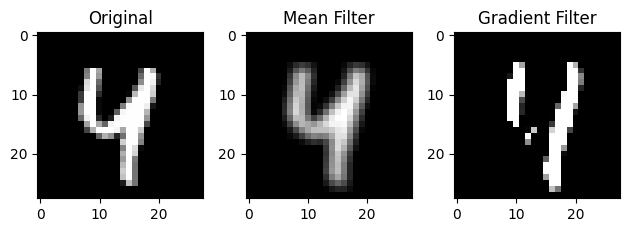

In [24]:
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
import cv2

test_set = datasets.MNIST(root='data', train=False, download=True)
image, label = test_set[42]

fig, axs = plt.subplots(nrows=1, ncols=3)

axs[0].imshow(image, cmap='gray')
axs[0].set_title('Original')

# Mean filter
weight = np.array([[1/9, 1/9, 1/9],
                   [1/9, 1/9, 1/9],
                   [1/9, 1/9, 1/9]])
filtered_image = cv2.filter2D(src=np.array(image), ddepth=-1, kernel=weight)
axs[1].imshow(filtered_image, cmap='gray')
axs[1].set_title('Mean Filter')

# X-derivative filter
weight = np.array([[1, 0, -1],
                   [2, 0, -2],
                   [1, 0, -1]])
filtered_image = cv2.filter2D(src=np.array(image), ddepth=-1, kernel=weight)
axs[2].imshow(filtered_image, cmap='gray')
axs[2].set_title('Gradient Filter')

fig.tight_layout()
fig.show()

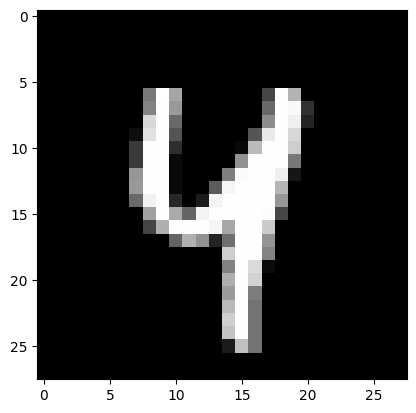

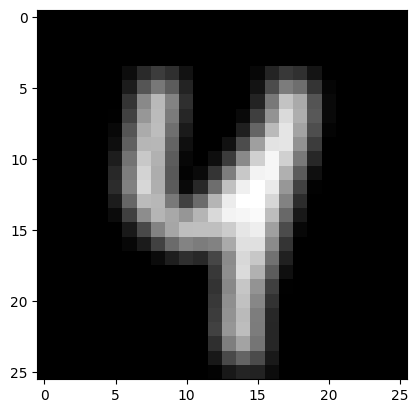

In [25]:
import torch
from torch import nn

conv = nn.Conv2d(in_channels=1, out_channels=1,
                 kernel_size=3, padding=0, stride=1)
with torch.no_grad():
    conv.weight[:] = torch.tensor([[1/9, 1/9, 1/9],
                                   [1/9, 1/9, 1/9],
                                   [1/9, 1/9, 1/9]])
    conv.bias.zero_()

from torchvision import transforms
image_as_tensor = transforms.ToTensor()(image)
convolution = conv(image_as_tensor).detach().numpy()[0]

plt.figure()
plt.imshow(image, cmap='gray')
plt.figure()
plt.imshow(convolution, cmap='gray')

# Convolutional Neural Networks (CNN)

## A more complex dataset: CIFAR-10
This time we use the CIFAR10 dataset, composed of RGB images of size 32 × 32.

The training and testing set contains respectively 50.000 and 10.000 images, each belonging to 10 different classes (airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and truck)

In [26]:
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
transf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),
                         std=(0.2023, 0.1994, 0.2010))
    ])
data_path = 'data'
cifar_train = datasets.CIFAR10(data_path,
                               train=True,
                               download=True,
                               transform=transf)
cifar_validation = datasets.CIFAR10(data_path,
                              train=False,
                              download=True,
                              transform=transf)
train_loader = torch.utils.data.DataLoader(cifar_train,
                                           batch_size=64,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar_validation,
                                          batch_size=64,
                                          shuffle=False)

label_to_class = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                  'dog', 'frog', 'horse', 'ship', 'truck']
print(f"Samples in training set: {len(cifar_train)}")
print(f"Samples in validation set: {len(cifar_validation)}")

100%|██████████| 170498071/170498071 [00:03<00:00, 47354461.02it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified
Samples in training set: 50000
Samples in validation set: 10000


## Defining the CNN architecture

In [27]:
from torch import nn
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.ReLU()
        self.fc2 = nn.Linear(32, 10)
    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8)
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

### Visualizing in `tensorboard`

In [ ]:
%load_ext tensorboard
from torch.utils.tensorboard import SummaryWriter
x = torch.rand(size=(1, 3, 32, 32))
writer = SummaryWriter("logs/")
model = Net()
writer.add_graph(model, x)
writer.close()
%tensorboard --logdir logs

## Training the CNN

In [36]:
learning_rate = 1e-2
epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = Net()
net.to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
loss_fn = torch.nn.CrossEntropyLoss()

In [37]:
from os import device_encoding
def train_epoch(model, train_loader, optimizer, loss_fn, device):
    train_loss = 0.0
    total = 0
    model.train()   # set training mode
    for samples, labels in train_loader:
        samples, labels = samples.to(device), labels.to(device)
        outputs = model(samples)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total += samples.shape[0]
        train_loss += loss.sum().detach()
    train_loss /= total
    return train_loss.item()

In [38]:
def valid_epoch(model, val_loader, loss_fn, device):
    accuracy = 0.0
    validation_loss = 0.0
    total = 0
    model.eval()    # set eval mode
    with torch.no_grad():
        for samples, labels in val_loader:
            samples, labels = samples.to(device), labels.to(device)
            outputs = net(samples)
            loss = loss_fn(outputs, labels)
            predictions = outputs.argmax(dim=1)
            accuracy += (predictions.type(labels.dtype) == labels).float().sum()
            total += samples.shape[0]
    validation_loss += loss.sum()
    validation_loss /= total
    accuracy = accuracy / total
    return validation_loss.item(), accuracy.item()

In [39]:
train_losses, val_losses = [], []
for epoch in range(epochs):
    train_loss = train_epoch(net, train_loader, optimizer, loss_fn, device)
    val_loss, accuracy = valid_epoch(net, val_loader, loss_fn, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Epoch [{epoch + 1}/{epochs}], "\
          f"Train loss: {train_loss:.4f}, "\
          f"Val. loss: {val_loss:.4f}, "\
          f"Val. accuracy: {accuracy:.4f}")

Epoch [1/10], Train loss: 0.0251, Val. loss: 0.0001, Val. accuracy: 0.5438
Epoch [2/10], Train loss: 0.0195, Val. loss: 0.0001, Val. accuracy: 0.5906
Epoch [3/10], Train loss: 0.0175, Val. loss: 0.0001, Val. accuracy: 0.6108
Epoch [4/10], Train loss: 0.0164, Val. loss: 0.0001, Val. accuracy: 0.6120
Epoch [5/10], Train loss: 0.0158, Val. loss: 0.0001, Val. accuracy: 0.6216
Epoch [6/10], Train loss: 0.0153, Val. loss: 0.0001, Val. accuracy: 0.6022
Epoch [7/10], Train loss: 0.0148, Val. loss: 0.0001, Val. accuracy: 0.6505
Epoch [8/10], Train loss: 0.0144, Val. loss: 0.0001, Val. accuracy: 0.6140
Epoch [9/10], Train loss: 0.0142, Val. loss: 0.0001, Val. accuracy: 0.6206
Epoch [10/10], Train loss: 0.0140, Val. loss: 0.0001, Val. accuracy: 0.6409


## Saving and loading the model

In [41]:
model_path = 'cifar_model.pt'
torch.save(net.state_dict(), model_path)

new_model = Net()
new_model.load_state_dict(torch.load(model_path))

new_model.eval()
val_loss, accuracy = valid_epoch(new_model, val_loader, loss_fn, device)
print("Accuracy of the loaded model: ", accuracy)

Accuracy of the loaded model:  0.6408999562263489


## ResNets

In [42]:
class ResBlock(nn.Module):
    def __init__(self, n_chans, dropout_rate=0):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3,
        padding=1, bias=False)
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        self.dropout = nn.Dropout(p=dropout_rate)
    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        out = self.dropout(out)
        return out + x # skip connection

class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1,
                               kernel_size=3,
                               padding=1)
        self.resblocks = nn.Sequential(
            *(n_blocks * [ResBlock(n_chans=n_chans1,
                                   dropout_rate=0.1)]))
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 10)
    def forward(self, x):
        out = torch.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = torch.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
learning_rate = 1e-2
epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = NetResDeep()
net.to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
loss_fn = torch.nn.CrossEntropyLoss()
train_losses, val_losses = [], []
for epoch in range(epochs):
    train_loss = train_epoch(net, train_loader, optimizer, loss_fn, device)
    val_loss, accuracy = valid_epoch(net, val_loader, loss_fn, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Epoch [{epoch + 1}/{epochs}], "\
          f"Train loss: {train_loss:.4f}, "\
          f"Val. loss: {val_loss:.4f}, "\
          f"Val. accuracy: {accuracy:.4f}")

# Finetuning a pre-trained model

In [43]:
from torchvision.models import resnet18, ResNet18_Weights
# Best available weights (currently alias for IMAGENET1K_V2)
# Note that these weights may change across versions
net = resnet18(weights=ResNet18_Weights.DEFAULT)

# replace the last layer for training on CIFAR-10
net.fc = nn.Linear(in_features=512, out_features=10, bias=True)

learning_rate = 1e-2
epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
loss_fn = torch.nn.CrossEntropyLoss()
train_losses, val_losses = [], []
for epoch in range(epochs):
    train_loss = train_epoch(net, train_loader, optimizer, loss_fn, device)
    val_loss, accuracy = valid_epoch(net, val_loader, loss_fn, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Epoch [{epoch + 1}/{epochs}], "\
          f"Train loss: {train_loss:.4f}, "\
          f"Val. loss: {val_loss:.4f}, "\
          f"Val. accuracy: {accuracy:.4f}")


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 58.5MB/s]


Epoch [1/10], Train loss: 0.0157, Val. loss: 0.0001, Val. accuracy: 0.7433
Epoch [2/10], Train loss: 0.0098, Val. loss: 0.0001, Val. accuracy: 0.7846
Epoch [3/10], Train loss: 0.0074, Val. loss: 0.0001, Val. accuracy: 0.7951
Epoch [4/10], Train loss: 0.0059, Val. loss: 0.0001, Val. accuracy: 0.8022
Epoch [5/10], Train loss: 0.0048, Val. loss: 0.0001, Val. accuracy: 0.8025
Epoch [6/10], Train loss: 0.0040, Val. loss: 0.0001, Val. accuracy: 0.7970
Epoch [7/10], Train loss: 0.0033, Val. loss: 0.0001, Val. accuracy: 0.8090
Epoch [8/10], Train loss: 0.0025, Val. loss: 0.0001, Val. accuracy: 0.8214
Epoch [9/10], Train loss: 0.0021, Val. loss: 0.0000, Val. accuracy: 0.8153
Epoch [10/10], Train loss: 0.0020, Val. loss: 0.0001, Val. accuracy: 0.8060
